In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 4.1 EDA a data preprocessing

### 4.1.1 Načítanie dát

In [100]:
df = pd.read_csv("NFLX.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4581 non-null   datetime64[ns]
 1   Open       4581 non-null   float64       
 2   High       4581 non-null   float64       
 3   Low        4581 non-null   float64       
 4   Close      4581 non-null   float64       
 5   Adj Close  4581 non-null   float64       
 6   Volume     4581 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 250.7 KB


(        Date      Open      High       Low     Close  Adj Close     Volume
 0 2002-05-23  1.156429  1.242857  1.145714  1.196429   1.196429  104790000
 1 2002-05-24  1.214286  1.225000  1.197143  1.210000   1.210000   11104800
 2 2002-05-28  1.213571  1.232143  1.157143  1.157143   1.157143    6609400
 3 2002-05-29  1.164286  1.164286  1.085714  1.103571   1.103571    6757800
 4 2002-05-30  1.107857  1.107857  1.071429  1.071429   1.071429   10154200,
 None,
                                 Date         Open         High          Low  \
 count                           4581  4581.000000  4581.000000  4581.000000   
 mean   2011-06-27 20:17:07.897838592    78.031471    79.285690    76.736079   
 min              2002-05-23 00:00:00     0.377857     0.410714     0.346429   
 25%              2006-12-07 00:00:00     3.778571     3.857143     3.685714   
 50%              2011-06-27 00:00:00    15.392858    15.671429    14.970000   
 75%              2016-01-14 00:00:00    97.830002    99

EDA – graf vývoja Close

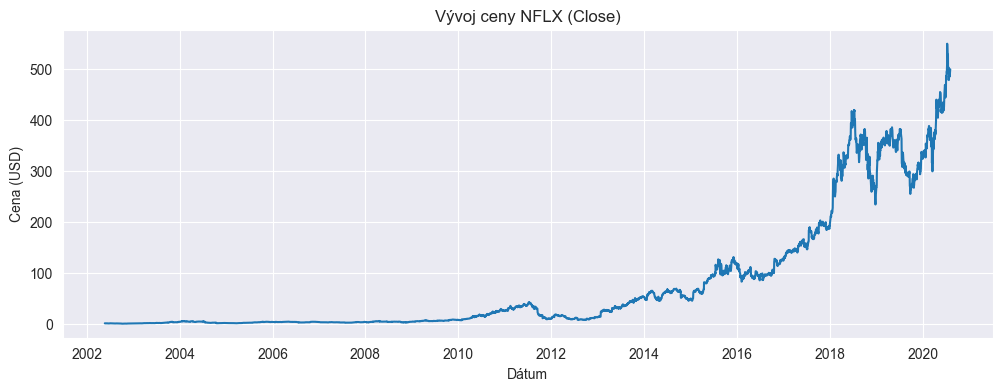

In [101]:
plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Close'])
plt.title("Vývoj ceny NFLX (Close)")
plt.xlabel("Dátum"); plt.ylabel("Cena (USD)")
plt.show()


Z grafu vývoja uzatváracej ceny (Close) môžeme pozorovať, že akcie Netflixu prešli za sledované obdobie výrazným rastom. V rokoch 2002–2010 sa cena pohybovala na nízkych úrovniach, typicky pod 10 USD. Okolo roku 2012 nastal prvý výraznejší rast, po ktorom nasledovalo obdobie zvýšenej volatility.

Najvýraznejší rast nastal medzi rokmi 2016–2020, kde cena prekročila hranicu 500 USD. Viditeľné sú tiež viaceré prudké výkyvy, čo naznačuje vysokú citlivosť akcie na trhové udalosti a rozhodnutia investorov.

Celkovo graf potvrdzuje, že ide o časový rad so silným rastovým trendom, ktorý nie je lineárny a obsahuje viacero období prudkých zmien. Preto je vhodné použiť pri modelovaní aj nelineárne metódy.

Volume plot

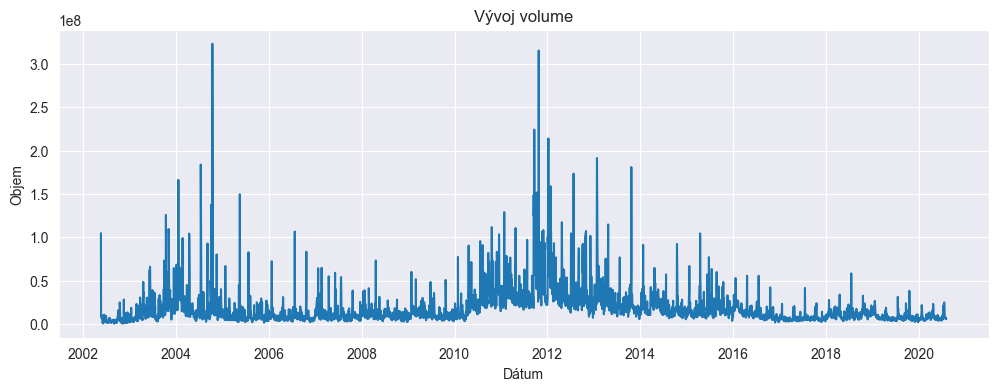

In [102]:
plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Volume'])
plt.title("Vývoj volume")
plt.xlabel("Dátum"); plt.ylabel("Objem")
plt.show()


Z grafu objemu obchodovania (Volume) vidíme, že medzi jednotlivými obdobiami existujú výrazné rozdiely. V niektorých dňoch obchodný objem presahuje hodnotu 300 miliónov, kým inokedy je relatívne nízky.

Najvýraznejšie špičky objemu sa vyskytujú okolo rokov 2004–2005 a 2011–2012, čo zvyčajne súvisí s dôležitými firmnými oznámeniami, kvartálnymi výsledkami alebo celkovou situáciou na trhu.

Objem obchodovania má kolísavý charakter a neukazuje jednoznačný dlhodobý trend, ale jeho náhle nárasty majú často dopad aj na cenu akcie. Preto môže byť Volume užitočnou doplnkovou premennou pre modelovania budúcej ceny.

Korelácie

In [103]:
corr = df[['Open','High','Low','Close','Adj Close','Volume']].corr()
corr

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999841,0.999830,0.999654,0.999654,-0.193770
High,0.999841,1.000000,0.999783,0.999840,0.999840,-0.192107
Low,0.999830,0.999783,1.000000,0.999834,0.999834,-0.195478
Close,0.999654,0.999840,0.999834,1.000000,1.000000,-0.193671
Adj Close,0.999654,0.999840,0.999834,1.000000,1.000000,-0.193671
Volume,-0.193770,-0.192107,-0.195478,-0.193671,-0.193671,1.000000


Pri korelačnej analýze sme použili základné cenové atribúty: Open, High, Low, Close, Adj Close a Volume. Ide o štandardnú skupinu premenných, ktoré opisujú vývoj akcie počas jedného obchodného dňa – otváraciu cenu, maximá, minimá, uzatváraciu cenu, upravenú cenu a objem obchodovania.

Výsledky ukazujú, že všetky cenové premenné sú medzi sebou extrémne silne korelované (kor. koeficienty ≈ 0.999). Je to prirodzené, keďže všetky tieto hodnoty reflektujú pohyb tej istej akcie v rovnakom časovom bode. Ak akcia rastie, rastú prakticky všetky cenové ukazovatele; ak klesá, klesajú rovnako.

Naopak, Volume vykazuje len slabú negatívnu koreláciu s cenou (~ –0.19), čo je bežné – objem obchodov síce často súvisí so zvýšenou volatilitou, ale nezodpovedá priamo absolútnej úrovni ceny.

Tieto zistenia potvrdzujú, že pri ďalšom modelovaní bude vhodné doplniť dáta o ďalšie odvodené premenné (lagy, kĺzavé priemery), aby model vedel zachytiť dynamiku časovej série a nebol založený iba na takmer identických vstupoch.

Preprocessing – tvorba lagov a rolling priemerov

In [104]:
lags = [1,3,5,10]
for lag in lags:
    df[f'Close_lag_{lag}'] = df['Close'].shift(lag)

df['Close_roll_3'] = df['Close'].rolling(window=3).mean()
df['Close_roll_7'] = df['Close'].rolling(window=7).mean()

df_model = df.dropna().reset_index(drop=True)


In [105]:
df_model.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_lag_1,Close_lag_3,Close_lag_5,Close_lag_10,Close_roll_3,Close_roll_7
0,2002-06-07,1.177857,1.177857,1.103571,1.118571,1.118571,1369200,1.182143,1.117857,1.076429,1.196429,1.149286,1.120306
1,2002-06-10,1.135000,1.175000,1.134286,1.156429,1.156429,484400,1.118571,1.147143,1.128571,1.210000,1.152381,1.132449
2,2002-06-11,1.156429,1.188571,1.128571,1.153571,1.153571,1003800,1.156429,1.182143,1.117857,1.157143,1.142857,1.143469
3,2002-06-12,1.153571,1.182143,1.089286,1.092857,1.092857,1799000,1.153571,1.118571,1.147143,1.103571,1.134286,1.138367
4,2002-06-13,1.104286,1.122143,1.080000,1.082857,1.082857,2567600,1.092857,1.156429,1.182143,1.071429,1.109762,1.133367


In [106]:
df_model.shape

(4571, 13)

In [107]:
df_model.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Close_lag_1', 'Close_lag_3', 'Close_lag_5', 'Close_lag_10',
       'Close_roll_3', 'Close_roll_7'],
      dtype='object')

Train/Test split + scaling

In [108]:
feature_cols = [
    'Open', 'High', 'Low', 'Volume',
    'Close_lag_1', 'Close_lag_3', 'Close_lag_5', 'Close_lag_10',
    'Close_roll_3', 'Close_roll_7'
]

X = df_model[feature_cols].values
y = df_model['Close'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=False  
)
len(X_train), len(X_test)

(3656, 915)

In [109]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [110]:
X_train_scaled[:5]

array([[-0.72018129, -0.72171448, -0.72113457, -0.87122919, -0.71998141,
        -0.72155656, -0.72248656, -0.71769886, -0.72120445, -0.72208874],
       [-0.72148006, -0.72179969, -0.72018831, -0.9128551 , -0.72190915,
        -0.72066647, -0.720898  , -0.71728323, -0.72111056, -0.72171936],
       [-0.72083066, -0.72139492, -0.72036438, -0.88841964, -0.72076116,
        -0.71960271, -0.72122441, -0.71890204, -0.72139945, -0.72138414],
       [-0.72091727, -0.72158665, -0.72157466, -0.851009  , -0.72084782,
        -0.72153486, -0.72033218, -0.72054274, -0.72165945, -0.72153933],
       [-0.72241084, -0.72337622, -0.72186075, -0.81484978, -0.72268889,
        -0.72038424, -0.71926587, -0.72152713, -0.72240334, -0.72169143]])

In [111]:
X_train_scaled.shape, X_test_scaled.shape

((3656, 10), (915, 10))

## 4.1.B – Zdôvodnenie výberu ML/DL metód

Pre daný dataset ide o finančný časový rad s nelineárnym vývojom ceny a možnými náhlymi zmenami. 
Ako základný referenčný model použijeme lineárnu regresiu, keďže ide o jednoduchú a dobre interpretovateľnú metódu, 
ktorá poskytuje baseline pre porovnanie.

Na zachytenie zložitejších nelineárnych vzťahov medzi cenou a odvodenými príznakmi (lagy, kĺzavé priemery, volume) 
použijeme aj model Random Forest Regressor. 
Ten je robustný voči šumu, nevyžaduje striktné predpoklady o linearite a často dosahuje lepšie výsledky na časových radoch tohto typu.

Kombináciou lineárneho a nelineárneho modelu vieme porovnať jednoduchší, vysvetliteľný prístup so zložitejším, 
ale potenciálne výkonnejším riešením, čo je vhodné pre úlohu v časti 4.2 (Modeling and evaluation).


## 4.2 Modeling and evaluation

### A – modelovanie vybraných charakteristík pomocou ML metód

Tréning modelov

In [112]:
# Lineárna regresia
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, random_state=42)

In [113]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Predikcie

In [114]:
y_pred_lr = lr.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test)


In [115]:
y_pred_rf[:5]

array([123.92573374, 123.4948995 , 125.61563336, 124.25116838,
       124.34936733])

Hodnotenie modelov

In [116]:
def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred)
    }

eval_lr = evaluate(y_test, y_pred_lr)
eval_rf = evaluate(y_test, y_pred_rf)

eval_lr, eval_rf

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


({'MAE': np.float64(1.7258880931443261),
  'RMSE': np.float64(2.466337722190519),
  'R2': 0.9993333206671091},
 {'MAE': np.float64(162.48000952971915),
  'RMSE': np.float64(188.4223171919529),
  'R2': -2.8911375400252863})

Graf predikcie

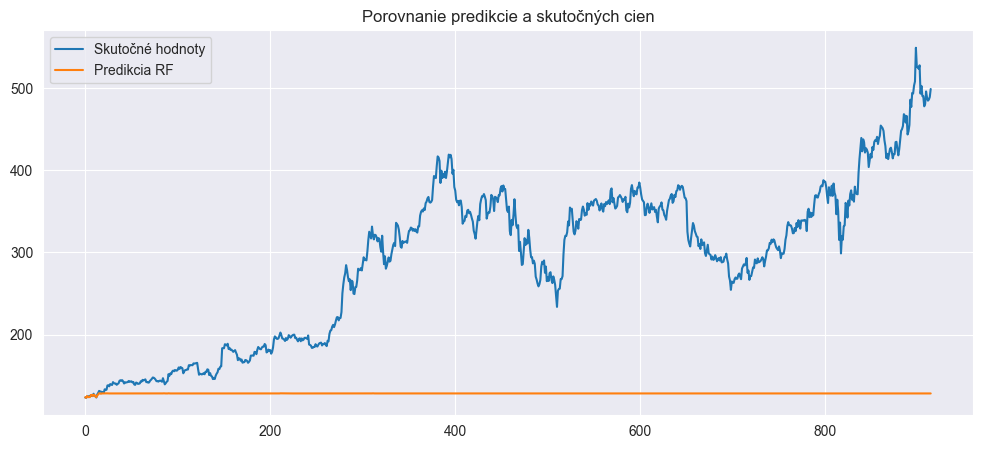

In [117]:
plt.figure(figsize=(12,5))
plt.plot(y_test, label="Skutočné hodnoty")
plt.plot(y_pred_rf, label="Predikcia RF")
plt.title("Porovnanie predikcie a skutočných cien")
plt.legend()
plt.show()
